### In this program we are trying to investigate how helpfulness is correlated with sentiment or emotions. The objective is to analyze the Amazon recommendation data-set to see how score, helpfulness and emotions/sentiment are all correlated. 
https://www.kaggle.com/snap/amazon-fine-food-reviews

In [50]:
%matplotlib inline

import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import numpy as np
import pickle as pickle
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cross_validation import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

### Loading the Data

In [55]:
file = open('reviews.pickle', 'rb')

if not file:
    #read from database in dataframe format
    con  = sqlite3.connect('./input/database/database.sqlite')
    messages = pd.read_sql_query("""
    SELECT Score, Summary
    FROM Reviews
    WHERE Score != 3
    """, con)

    #function to assign label (if > 3 postitive else: negative - 3 not considered)
    def assign_labels(x):
        if x < 3:
            return 'negative'
        return 'positive'

    #obtain columns
    scores = messages['Score']
    scores = scores.map(partition)
    summaries = messages['Summary']
    
    #function to turn data into pickle for later ease and convenience of use
    pickle_file = 'reviews.pickle'
    def data_to_pickle(scores, summaries):
        try:
            f = open(pickle_file, 'wb')
            save = {
                'scores': scores,
                'summaries': summaries,
            }
            pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)
            f.close()
        except Exception as e:
            print ('Unable to save data to', pickle_file, ':', e)
            raise

    data_to_pickle(scores, summaries)

#pull data from pickle
file = open('reviews.pickle', 'rb')
data = pickle.load(file)

scores, summaries = data['scores'],data['summaries']

X_train,  X_test, y_train, y_test = train_test_split(summaries, scores, test_size=0.2, random_state=42)

### Pre-processing Data

In [128]:
stemmer = PorterStemmer()
from nltk.corpus import stopwords
import re

neg_words = ['never','no','nothing','nowhere','noone','none','not','havent','hasnt','hadnt',
'cant','couldnt','shouldnt','wont','wouldnt','dont','doesnt','didnt','isnt','arent','aint']

#function to analyze the amount of negative terms in corpus
def get_neg_words(text):
    tokens = nltk.word_tokenize(text)
    neg_words_retrieved = [word for word in tokens if word in neg_words]
    return len(neg_words_retrieved)
        
#function to implement the stemming
def stem_tokens(tokens, stemmer):
    stemmed = []
    for item in tokens:
        stemmed.append(stemmer.stem(item))
    return stemmed

#function to tokenize text
def tokenize(text):
    tokens = nltk.word_tokenize(text)
    #tokens = [word for word in tokens if word not in stopwords.words('english') or word in neg_words]
    stems = stem_tokens(tokens, stemmer)
    return ' '.join(stems)

#turn punctuations into whitespaces
#intab = string.punctuation.strip("'")
#outtab = "                                "
#trantab = str.maketrans(intab, outtab)

#replace punctuation expression by using a regular expression instead
regex = re.compile('[%s]' % re.escape(string.punctuation))

### Preparing and Analyzing the Data

In [129]:
#preparing the training dataset

corpus = []
neg_words_counter = 0

for text in X_train:
    text = text.lower()
    #text = text.translate(trantab)
    text = regex.sub('', text)
    #neg_words_counter = neg_words_counter + get_neg_words(text)
    
    text=tokenize(text)
    corpus.append(text)

In [130]:
print (neg_words_counter)

0


In [131]:
print (corpus[:30])

['almond great buy', 'i never thought id have to say no to more fruit and veggi', 'we love thi stuff', 'fanfriggentast', 'great for offic', 'what have they done', 'cri babi tear', 'good cereal with a few potenti health concern', 'a quick meal', 'good flavor', 'best bbq sauc ever', 'best lemonad mix ive bought', 'if you like the tast of chai you will love thi', 'the best basic ramen noodl out there', 'huge bag', 'great experi', 'good stuff', 'good stuff', 'count them', 'the best popcorn for your health', 'thi is great oil', 'chocol chip cooki youll love to bake up with your kid anytim', 'cant be beat', 'delici', 'one of the most import miner for asthmat', 'bewar', 'great cooki and lot of fun', 'horribl product', 'awesom coffe', 'green chai a big hit']


In [132]:
count_vect = CountVectorizer(ngram_range=(1,2))
X_train_counts = count_vect.fit_transform(corpus) 

#### Note: CountVectorizers count the number of words that are in the corpus. 
#### TODO: After some analysis the bag of words could be improved by improving the punctuation replacement and removing words shorter than two letters (ok, I , m, etc.,). 
#### TODO: bigrams can also be adopted
#### TODO: Remove repeated words???
#### TODO: Remove the concepts (they are basically just wildcards)
#### TODO: Remove stop words but only leave the non-

In [133]:
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

In [134]:
#preparing the test data-set

test_set = []
for text in X_test:
    text = text.lower()
    #text = text.translate(trantab)
    
    text = regex.sub('', text)
    
    text=tokenize(text)
    test_set.append(text)

In [135]:
X_new_counts = count_vect.transform(test_set)
X_test_tfidf = tfidf_transformer.transform(X_new_counts)

### Training Models

In [136]:
from pandas import *
#df = DataFrame({'Before': X_train, 'After': corpus})
#print(df.head(20))

prediction = dict()

#MNB
from sklearn.naive_bayes import MultinomialNB
model = MultinomialNB().fit(X_train_tfidf, y_train)
prediction['Multinomial'] = model.predict(X_test_tfidf)

#BNB
from sklearn.naive_bayes import BernoulliNB
model = BernoulliNB().fit(X_train_tfidf, y_train)
prediction['Bernoulli'] = model.predict(X_test_tfidf)

#Logistic regression
from sklearn import linear_model
logreg = linear_model.LogisticRegression(C=1e5)
logreg.fit(X_train_tfidf, y_train)
prediction['Logistic'] = logreg.predict(X_test_tfidf)

### Results

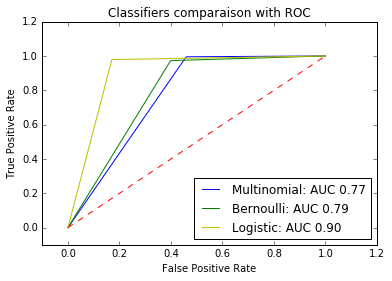

In [137]:
def formatt(x):
    if x == 'negative':
        return 0
    return 1
vfunc = np.vectorize(formatt)

cmp = 0
colors = ['b', 'g', 'y', 'm', 'k']
for model, predicted in prediction.items():
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test.map(formatt), vfunc(predicted))
    roc_auc = auc(false_positive_rate, true_positive_rate)
    plt.plot(false_positive_rate, true_positive_rate, colors[cmp], label='%s: AUC %0.2f'% (model,roc_auc))
    cmp += 1

plt.title('Classifiers comparaison with ROC')
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.2])
plt.ylim([-0.1,1.2])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [138]:
print(metrics.classification_report(y_test, prediction['Logistic'], target_names = ["positive", "negative"]))

             precision    recall  f1-score   support

   positive       0.88      0.83      0.85     16379
   negative       0.97      0.98      0.97     88784

avg / total       0.95      0.96      0.96    105163



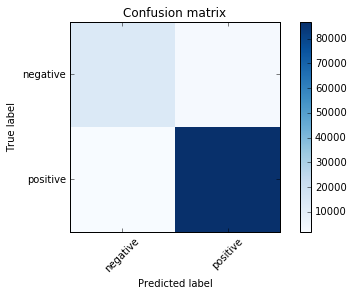

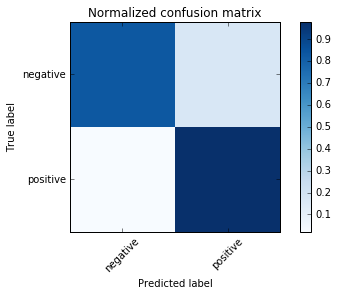

In [140]:
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(set(Score)))
    plt.xticks(tick_marks, set(Score), rotation=45)
    plt.yticks(tick_marks, set(Score))
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
# Compute confusion matrix
cm = confusion_matrix(y_test, prediction['Logistic'])
np.set_printoptions(precision=2)
plt.figure()
plot_confusion_matrix(cm)    

cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plt.figure()
plot_confusion_matrix(cm_normalized, title='Normalized confusion matrix')

plt.show()